In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from statsmodels.sandbox.regression.gmm import IV2SLS

In [2]:
# First I upload the dataset of Real Median Wages Adjusted for Cost of Living over every county in the US, and
# index it by year.
df_col_wage = pd.read_csv("RealMedWagesAdjColAll.csv", index_col=0, skiprows=3)
df_col_wage.index = pd.to_datetime(df_col_wage.index).year
df_col_wage.index.rename("Date", inplace=True)

# However, since my analysis is by metro area, I map each county to it's respective metro area and take the average
# wage to get an approximate median wage for each metro area.
df_metros = pd.read_csv('metrolist.csv', names = ['Metro', 'County'])

med_wage_met = df_col_wage.transpose().merge(df_metros, left_index=True, right_on='County')
df_wages = med_wage_met.groupby('Metro').mean()

Real Median Wages Adjusted for Cost of Living will be my response variable. This is because it will best allow me to compare the economic welfare across metro areas. Since my analysis is going to be comaparing different housing statistics across different metro areas to see which ones have the greatest affect on net income, this makes sense.

In [3]:
# Next I get the ratio of single unit building permits to building permits for any size

# First I upload the dataset of all building permits for all metro areas and index it by year and drop metros with 
# null values
df_any_permits = pd.read_csv('AnyBuildPermitsAll.csv', index_col=0, skiprows=2)
df_any_permits.index = pd.to_datetime(df_any_permits.index).year
df_any_permits.index.rename('Date', inplace=True)
df_any_permits.dropna(axis=1, inplace=True)

# Strip the whitespace before and after each metro name
new_cols = []
for i in df_any_permits.columns:
    new_cols.append(i.strip())
    
df_any_permits.columns = new_cols


# Upload the dataset of Single Unit building permits for all metro areas and index it by year and drop metros with
# null values
df_spermits = pd.read_csv('SBuildPermitsAll.csv', index_col=0, skiprows=3)
df_spermits.index = pd.to_datetime(df_spermits.index).year
df_spermits.index.rename('Date', inplace=True)
df_spermits.dropna(axis=1, inplace=True)

# Strip whitespace
new_cols = []
for i in df_spermits.columns:
    new_cols.append(i.strip())
    
df_spermits.columns = new_cols

# Merge the two dataframes on metro area
all_permits = df_spermits.transpose().merge(df_any_permits.transpose(), left_index=True, right_index = True,
                                            suffixes = ("_Single", "_Any"))
all_permits.index.rename('Metro', inplace=True)
all_permits.drop(['2021_Single', '2021_Any'], inplace=True, axis=1)


# Here I find the percent of permits that are for single unit development by looping through the columns
years = np.arange(2000,2021)
for yr in years:
    all_permits[str(yr)+'_Ratio'] = (all_permits[str(yr)+'_Single']/all_permits[str(yr)+'_Any'])*100
    
df_ratios = all_permits[all_permits.columns[44:]]

# Get rid of the _Ratio suffix in the new dataframe
yrs =[]
for yr in df_ratios.columns:
    yrs.append(int(yr.replace("_Ratio", '')))
    
df_ratios.columns = yrs


In [4]:
# Next I get Housing Price Index, index it by year and drop metros with null values
df_hpi = pd.read_csv('ATHPIAll.csv', index_col=0, skiprows=3)
df_hpi.index = pd.to_datetime(df_hpi.index).year
df_hpi.index.rename('Date', inplace=True)
df_hpi.dropna(axis=1, inplace=True)

# Strip whitespace
new_cols = []
for i in df_hpi.columns:
    new_cols.append(i.strip())
    
df_hpi.columns = new_cols

# Transpose it to get Metros in the rows and years in the columns
df_hpi = df_hpi.transpose()
df_hpi.index.rename('Metro', inplace=True)


In [5]:
# Now I get the Regional Price Parities, index by year, and drop metros with null values
df_rpp = pd.read_csv('RPPAll.csv', index_col=0, skiprows=3)
df_rpp.index = pd.to_datetime(df_rpp.index).year
df_rpp.index.rename('Date', inplace=True)
df_rpp.dropna(axis=1, inplace=True)

#Strip whitespace
new_cols = []
for i in df_rpp.columns:
    new_cols.append(i.strip())
    
df_rpp.columns = new_cols

#Transpose it to get metros in the rows and years in the columns
df_rpp = df_rpp.transpose()
df_rpp.index.rename('Metro', inplace=True)



In [6]:
# Here I flatten the dataframes to get each metro in each year as a single observation
def flatten_df(df: pd.DataFrame, date_range: np.array, data_name: str):    
    city = []
    year = []
    data = []
    df.reset_index(inplace=True)
    for index, item in df.iterrows():
        for i in date_range:
            city.append(item['Metro'])
            year.append(i)
            data.append(item[i])
            
    flat_df = pd.DataFrame({'Metro':city, 'Year':year, data_name:data})
            
    return flat_df
        
    
flat_ratios = flatten_df(df_ratios, np.arange(2002,2021), 'Permit_Ratios')
flat_wages = flatten_df(df_wages, np.arange(2009,2020), 'Real_Wages')
flat_hpi = flatten_df(df_hpi, np.arange(2000,2022), 'HPI')
flat_rpp = flatten_df(df_rpp, np.arange(2008, 2021), 'RPP')

In [7]:
# I find the HPI of the previous year to use as a lagged variable, and drop the year 2000 since that will be 
# a null value
flat_hpi['Prev_HPI'] = flat_hpi['HPI'].shift(1)
flat_hpi = flat_hpi[flat_hpi['Year']!=2000]

flat_ratios['Prev_Ratio'] = flat_ratios['Permit_Ratios'].shift(1)
flat_ratios = flat_ratios[flat_ratios['Year']>2002]

In [8]:
# Upload vacancies and filter out the Micropolitan areas
df_vac = pd.read_csv('VacanciesAll.csv')
df_vac = df_vac[df_vac['Metro'].str.contains('Metro')]
df_vac.rename({'Rate':'Vac_Rate'},axis=1,inplace=True)

# Clean the metro names
new_col = []
for index, item in df_vac.iterrows():
    new_item = item['Metro'].replace('Metro Area', '')
    new_item = new_item.strip()
    new_col.append(new_item)
    
df_vac['Metro'] = new_col

df_vac = df_vac.sort_values(['Metro', 'Year'], ascending=[True, True])

df_vac['Vac_Rate'] = df_vac['Vac_Rate']*100
df_vac['Prev_VRate'] = df_vac['Vac_Rate'].shift(1)
df_vac.fillna(value=df_vac['Prev_VRate'].mean(), inplace=True)

In [9]:
# Upload populations and filter out Micropolitan areas
df_pop = pd.read_csv('MetroPopulations.csv')
df_pop = df_pop[df_pop['Metro'].str.contains('Metro')]

# Clean the metro names
new_col = []
for index, item in df_pop.iterrows():
    new_item = item['Metro'].replace('Metro Area', '')
    new_item = new_item.strip()
    new_col.append(new_item)
    
df_pop['Metro'] = new_col


In [10]:
# Strip whitespace from the wages dataframe
new_col = []
for index, item in flat_wages.iterrows():
    new_col.append(item['Metro'].strip())
    
flat_wages['Metro'] = new_col

In [11]:
# Combine the variables into one dataframe, merging on metro area and year
df_housing = flat_ratios.merge(flat_hpi, on=['Metro', 'Year'])
df_housing = df_housing.merge(df_vac, on=['Metro', 'Year'])
df_housing = df_housing.merge(flat_rpp, on=['Metro', 'Year'])
df_housing = df_housing.merge(df_pop, on=['Metro', 'Year'])
df_housing['Pop_per_unit'] = df_housing['Population']/df_housing['Total']
df_housing = df_housing.sort_values(['Metro', 'Year'], ascending=[True, True])
df_housing['Prev_PPU'] = df_housing['Pop_per_unit'].shift(1)
df_housing['Prev_PPU'].fillna(value=df_housing['Prev_PPU'].mean())
df_housing = df_housing.merge(flat_wages, on=['Metro', 'Year'])

In [12]:
# Create a standardized version of dataframe for potential use in comparison
df_x = df_housing[['HPI', 'Prev_HPI', 'RPP', 'Real_Wages', 'Permit_Ratios', 'Vac_Rate', 'Pop_per_unit', 
                   'Prev_VRate', 'Prev_Ratio', 'Prev_PPU']]

df_housing_std = df_housing.copy()

df_housing_std[['HPI', 'Prev_HPI', 'RPP', 'Real_Wages', 'Permit_Ratios', 'Vac_Rate', 
                'Pop_per_unit', 'Prev_VRate', 'Prev_Ratio', 'Prev_PPU']] = (df_x-df_x.mean())/df_x.std()

Here I plot a correlation matrix to make sure my IVs are correlated with their respective regressors but not the
response variable. Prev_HPI seems like it might be too correlated with real wages so I may remove HPI as a 
regressor depending on the regression outputs.

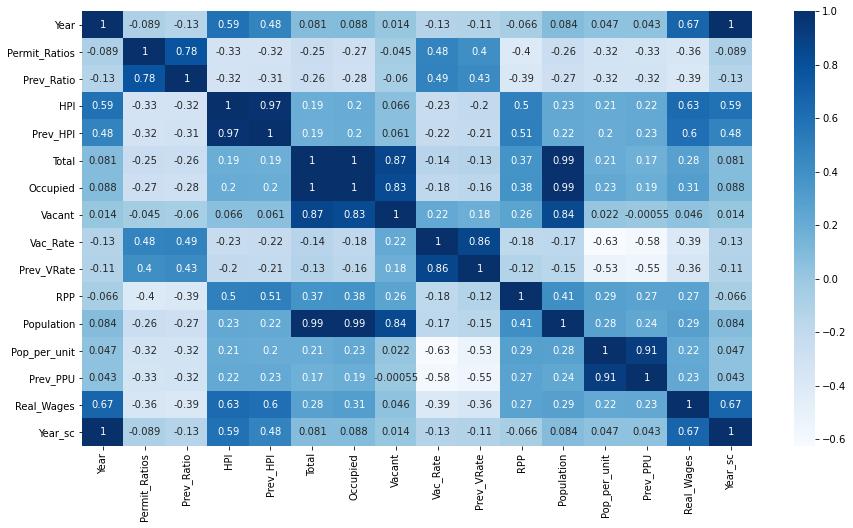

In [23]:
corr = df_housing.corr()
plt.figure(figsize=(15,8))
_ = sns.heatmap(corr,  annot=True, cmap='Blues')

I plot an OLS regression with all my variables and without the instruments as a starting point. The output looks ok but is says I have a strong multicollinearity issue, so I have to deal with that.

In [14]:
# Get feature and response variables
X = df_housing[['Year','Permit_Ratios', 'HPI','Vac_Rate', 'RPP', 'Prev_HPI', 'Pop_per_unit']]
X = pd.get_dummies(X, columns=['Year'])
X = sm.add_constant(X)
y = df_housing['Real_Wages']

# Fit regression
result = sm.OLS(y, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             Real_Wages   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     89.73
Date:                Thu, 24 Mar 2022   Prob (F-statistic):          1.51e-122
Time:                        22:26:46   Log-Likelihood:                -1174.8
No. Observations:                 450   AIC:                             2382.
Df Residuals:                     434   BIC:                             2447.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -8.5881      4.680     -1.835

I try a Ridge regression next, but this doesn't do much to help as the R-squared values and coefficients are all very similar to the OLS regression.

In [15]:
X = df_housing[['Year','Permit_Ratios', 'HPI','Vac_Rate', 'RPP', 'Prev_HPI', 'Pop_per_unit']]
X = pd.get_dummies(X, columns=['Year'])
y = df_housing['Real_Wages']

# Find optimal alpha
ridgeReg = RidgeCV(alphas=[1e-6, 1e-4, 1e-2, 1], cv=10, normalize=True).fit(X, y)
alph = ridgeReg.alpha_

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1680)

# Fit the regression
ridge = Ridge(alpha=alph, normalize=True)
model = ridge.fit(X_train,y_train)

# Make dataframe of coefficients
summary = pd.DataFrame({'var':X.columns, 'ols_val':result.params.tolist()[1:], 'ridge_val':ridge.coef_})
display(summary)
print("In sample accuracy: ", model.score(X_train, y_train))
print("Out of sample accuracy: ", model.score(X_test, y_test))

,var,ols_val,ridge_val
0,Permit_Ratios,-0.053649,-0.051290
1,HPI,-0.104260,-0.062326
2,Vac_Rate,-0.293569,-0.307336
3,RPP,0.451945,0.385383
4,Prev_HPI,0.106133,0.061025
5,Pop_per_unit,-1.706420,-2.174649
6,Year_2010,-5.875186,-4.155503
7,Year_2011,-6.816329,-5.192202
8,Year_2012,-6.012417,-4.811866
9,Year_2013,-4.708128,-4.364370


In sample accuracy:  0.7452792446623939
Out of sample accuracy:  0.7521340513171997


I use PCA next. I tried this ina  few different ways and found this to be the optimal one. When I didn't include the year in the computaton of the principal components I still got a multicollinearity error, and when I excldued year entirely I got an R-squared of just 0.31. When I tried using three PCs, the third was insignificant.

While this does get rid of the multicollinearity problem, it still has a relatively low R-squared of 0.61, so I'm still missing a lot of variance.

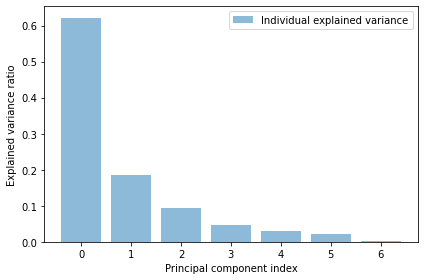

In [16]:
# Intitialize PCA object and feature matrix
pca = PCA()
X = df_housing_std[['Year', 'Permit_Ratios', 'HPI','Vac_Rate', 'RPP', 'Prev_HPI', 'Pop_per_unit']]

# Fit and transform the features and plot by explained variance ratio
X_pca = pca.fit_transform(X)
exp_var_pca = pca.explained_variance_ratio_
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [17]:
# Transform the data into its first two principal components
n = 2
pca_n = PCA(n_components=n)
pca_vals = pca_n.fit_transform(X)

In [18]:
# Create dataframe to run regression on
pc_df = pd.DataFrame({"PC1":pca_vals[:,0], "PC2":pca_vals[:,1],
                      "Real_Wages":df_housing['Real_Wages'].tolist()})


X = pc_df[['PC1', 'PC2']]
X = sm.add_constant(X)
y = pc_df['Real_Wages']

result = sm.OLS(y, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             Real_Wages   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     349.9
Date:                Thu, 24 Mar 2022   Prob (F-statistic):           3.55e-92
Time:                        22:26:46   Log-Likelihood:                -1280.3
No. Observations:                 450   AIC:                             2567.
Df Residuals:                     447   BIC:                             2579.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.3045      0.197    118.352      0.0

Now I try with the instrumental variables and get much better results. Still, the coefficient of HPI confuses me here, especially since I was suspicious of it before from the correlation matrix. Based on my starting assumptions, a higher HPI would indicate a scarser housing market and therefore lower real wages. Perhaps the Prev_HPI is insrtument is still too correlated with the repsonse variable and I should exclude HPI entirely from the model.

In [19]:
# Scale the year since fixed effects won't work with IV2SLS
year = []
for index, item in df_housing.iterrows():
    year.append(item['Year']-2010)
    
df_housing['Year_sc'] = year
X = df_housing[['Year_sc','Permit_Ratios', 'HPI','Vac_Rate', 'RPP', 'Pop_per_unit']]

# Add the IVs
IV_x = df_housing[['Year_sc','Permit_Ratios', 'HPI','Vac_Rate', 'RPP', 'Pop_per_unit', 'Prev_HPI', 
                   'Prev_Ratio', 'Prev_VRate', 'Prev_PPU']]

# Tried retaining the year fixed effects, but it wouldn't work with IV2SLS
#X = pd.get_dummies(X, columns=['Year'])
#X = sm.add_constant(X)
y = df_housing['Real_Wages']

IV_specs = IV2SLS(y, X, instrument=IV_x).fit()

print(IV_specs.summary())

                          IV2SLS Regression Results                           
Dep. Variable:             Real_Wages   R-squared:                       0.972
Model:                         IV2SLS   Adj. R-squared:                  0.971
Method:                     Two Stage   F-statistic:                       nan
                        Least Squares   Prob (F-statistic):                nan
Date:                Thu, 24 Mar 2022                                         
Time:                        22:26:46                                         
No. Observations:                 450                                         
Df Residuals:                     444                                         
Df Model:                           6                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Year_sc           1.2977      0.090     14.394

Finally when I remove HPI as a variable, I get similarly strong results that make more sense based on the regression output and the correlation matrix.

In [20]:
# Remake the dataframes without HPI
X = df_housing[['Year_sc','Permit_Ratios','Vac_Rate', 'RPP', 'Pop_per_unit']]
IV_x = df_housing[['Year_sc','Permit_Ratios','Vac_Rate', 'RPP', 'Pop_per_unit', 
                   'Prev_Ratio', 'Prev_VRate', 'Prev_PPU']]

y = df_housing['Real_Wages']

IV_specs = IV2SLS(y, X, instrument=IV_x).fit()

print(IV_specs.summary())

                          IV2SLS Regression Results                           
Dep. Variable:             Real_Wages   R-squared:                       0.971
Model:                         IV2SLS   Adj. R-squared:                  0.971
Method:                     Two Stage   F-statistic:                       nan
                        Least Squares   Prob (F-statistic):                nan
Date:                Thu, 24 Mar 2022                                         
Time:                        22:26:46                                         
No. Observations:                 450                                         
Df Residuals:                     445                                         
Df Model:                           5                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Year_sc           1.5013      0.070     21.565